In [ ]:
import math
import asyncio
import warnings
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from typing import Optional, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from datasets import load_dataset # Library to load datasets easily
from torch.cuda.amp import autocast, GradScaler # For mixed precision training
from torch.utils.data import Dataset, DataLoader # For data handling

from sklearn.metrics import confusion_matrix # For model evaluation

In [ ]:
warnings.simplefilter("ignore") # Ignore warnings for cleaner output

### Preparção do Dataset

In [ ]:
dataset = load_dataset("ag_news"); # Load the AG News dataset

train_texts = dataset["train"]["text"]
train_labels = dataset["train"]["label"]

test_texts = dataset["test"]["text"]
test_labels = dataset["test"]["label"]

print(f"Train samples: {len(train_labels)}") # Print number of training samples
print(f"Test samples: {len(test_labels)}") # Print number of testing samples

print()

label_map = { # Map numerical labels to human-readable categories
    0: "World",
    1: "Sports",
    2: "Business",
    3: "Sci/Tech",
}

print(f"Text 1 sample: {train_texts[0]}") # Display a sample training text
print(f"Label 1 sample: {label_map.get(train_labels[0])}") # Display its corresponding label

print()

print(f"Text 2 sample: {train_texts[-1]}") # Display another sample training text
print(f"Label 2 sample: {label_map.get(train_labels[-1])}") # Display its corresponding label

Train samples: 120000
Test samples: 7600

Text 1 sample: Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.
Label 1 sample: Business

Text 2 sample: Nets get Carter from Raptors INDIANAPOLIS -- All-Star Vince Carter was traded by the Toronto Raptors to the New Jersey Nets for Alonzo Mourning, Eric Williams, Aaron Williams, and a pair of first-round draft picks yesterday.
Label 2 sample: Sports


In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self,
                 d_model:   int,
                 num_heads: int,
                 dropout:   float = 0.1) -> None:

        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads # Dimension of each head

        # Linear layers for Query, Key, Value, and output projection
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)
        self.scale = math.sqrt(self.d_k) # Scaling factor for attention scores

    def split_heads(self, X: torch.Tensor) -> torch.Tensor:
        # Reshapes input for multi-head attention
        batch_size, seq_len, d_model = X.size()
        return X.view(
            batch_size,
            seq_len,
            self.num_heads,
            self.d_k
        ).transpose(1, 2) # Transpose to get (batch_size, num_heads, seq_len, d_k)

    def forward(self,
                query: torch.Tensor,
                key:   torch.Tensor,
                value: torch.Tensor,
                mask:  Optional[torch.Tensor] = None) -> torch.Tensor:

        batch_size = query.size(0)

        # Project and split Query, Key, Value into multiple heads
        Q = self.split_heads(self.W_q(query))
        K = self.split_heads(self.W_k(key))
        V = self.split_heads(self.W_v(value))

        # Calculate attention scores
        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e4) # Apply mask to attention scores

        attention_weights = F.softmax(scores, dim=-1) # Apply softmax to get probabilities
        attention_weights = self.dropout(attention_weights) # Apply dropout

        context = torch.matmul(attention_weights, V) # Calculate weighted sum of values

        # Concatenate heads and apply final linear projection
        context = context.transpose(1, 2).contiguous().view(
            batch_size,
            -1,
            self.d_model
        )

        output = self.W_o(context)

        return output

In [ ]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self,
                 d_model: int,
                 d_ff:    int,
                 dropout: float = 0.1) -> None:

        super(PositionwiseFeedForward, self).__init__()

        # Two linear layers with a non-linear activation (GELU) in between
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        return self.linear2(self.dropout(F.gelu(self.linear1(X)))) # Forward pass: linear -> GELU -> dropout -> linear

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self,
                 d_model: int,
                 max_len: int = 5000,
                 dropout: float = 0.1) -> None:

        super(PositionalEncoding, self).__init__()

        self.dropout = nn.Dropout(dropout)

        pe = torch.zeros(max_len, d_model) # Initialize positional encoding matrix
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1) # Positions for each token
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model) # Division term for sine/cosine arguments
        )

        pe[:, 0::2] = torch.sin(position * div_term) # Apply sine to even indices
        pe[:, 1::2] = torch.cos(position * div_term) # Apply cosine to odd indices

        pe = pe.unsqueeze(0) # Add batch dimension
        self.register_buffer("pe", pe) # Register pe as a buffer, not a parameter

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        X = X + self.pe[:, :X.size(1), :] # Add positional embeddings to input embeddings
        return self.dropout(X) # Apply dropout

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self,
                 d_model:   int,
                 num_heads: int,
                 d_ff:      int,
                 dropout:   float = 0.1) -> None:

        super(EncoderLayer, self).__init__()

        self.self_attention = MultiHeadAttention(d_model, num_heads, dropout) # Multi-head self-attention module
        self.feed_forward = PositionwiseFeedForward(d_model, d_ff, dropout) # Position-wise feed-forward network

        self.norm1 = nn.LayerNorm(d_model) # Layer normalization after attention
        self.norm2 = nn.LayerNorm(d_model) # Layer normalization after feed-forward

        self.dropout1 = nn.Dropout(dropout) # Dropout for attention output
        self.dropout2 = nn.Dropout(dropout) # Dropout for feed-forward output

    def forward(self,
                X:    torch.Tensor,
                mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        # Self-attention sub-layer with residual connection and layer normalization
        attn_output = self.self_attention(X, X, X, mask)
        X = self.norm1(X + self.dropout1(attn_output))

        # Feed-forward sub-layer with residual connection and layer normalization
        ff_output = self.feed_forward(X)
        X = self.norm2(X + self.dropout2(ff_output))

        return X

In [ ]:
class TransformerClassifier(nn.Module):
    def __init__(self,
                 vocab_size:  int,
                 num_classes: int,
                 d_model:     int = 512,
                 num_heads:   int = 8,
                 num_layers:  int = 6,
                 d_ff:    int = 2048,
                 max_len: int = 512,
                 pad_idx: int = 0,
                 dropout: float = 0.1) -> None:

        super(TransformerClassifier, self).__init__()

        self.d_model = d_model
        self.pad_idx = pad_idx

        self.embedding = nn.Embedding( # Token embedding layer
            vocab_size,
            d_model,
            padding_idx=pad_idx
        )
        self.positional_encoding = PositionalEncoding( # Positional encoding layer
            d_model,
            max_len,
            dropout
        )

        self.encoder_layers = nn.ModuleList([ # Stack of Encoder Layers
            EncoderLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])

        self.classifier = nn.Sequential( # Classification head
            nn.Linear(d_model, d_model // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, num_classes)
        )

        self._init_weights() # Initialize model weights

    def _init_weights(self):
        # Custom weight initialization
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def create_padding_mask(self, X: torch.Tensor) -> torch.Tensor:
        # Create a boolean mask to ignore padding tokens
        mask = (X != self.pad_idx).unsqueeze(1).unsqueeze(2)
        return mask

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        mask = self.create_padding_mask(X) # Generate padding mask

        X = self.embedding(X) * math.sqrt(self.d_model) # Apply token embedding and scale
        X = self.positional_encoding(X) # Add positional encoding

        for layer in self.encoder_layers:
            X = layer(X, mask) # Pass through each encoder layer

        # Global average pooling on the output of the transformer encoder
        mask_expanded = mask.squeeze(1).squeeze(1).unsqueeze(-1).float()
        pooled = (X * mask_expanded).sum(dim=1) / mask_expanded.sum(dim=1)

        logits = self.classifier(pooled) # Pass pooled output through the classifier

        return logits

In [ ]:
class  Vocabulary:
    def __init__(self, max_vocab_size: int = 30000) -> None:

        self.max_vocab_size = max_vocab_size

        # Special tokens for padding, unknown words, start-of-sentence, end-of-sentence
        self.word2idx = {'<PAD>': 0, '<UNK>': 1, '<SOS>': 2, '<EOS>': 3}
        self.idx2word = {0: '<PAD>', 1: '<UNK>', 2: '<SOS>', 3: '<EOS>'}

        self.word_counts = Counter() # To count word frequencies

    def build_vocab(self, texts: list) -> None:
        # Builds the vocabulary from a list of texts
        for text in texts:
            tokens = self.tokenize(text)
            self.word_counts.update(tokens)

        # Add most common words to vocabulary, excluding special tokens
        most_common = self.word_counts.most_common(self.max_vocab_size - 4)
        for idx, (word, _) in enumerate(most_common, start=4):
            self.word2idx[word] = idx
            self.idx2word[idx] = word

    def tokenize(self, text: str) -> list:
        # Simple tokenization by lowercasing and splitting by space
        return text.lower().split()

    def encode(self, text: str, max_len: int = 256) -> list:
        # Converts a text into a sequence of numerical indices
        tokens = self.tokenize(text)[:max_len] # Tokenize and truncate to max_len
        indices = [self.word2idx.get(token, 1) for token in tokens] # Map tokens to indices, using <UNK> for unknown
        return indices

    def __len__(self) -> int:
        return len(self.word2idx) # Returns the size of the vocabulary

In [ ]:
class AGNewsDataset(Dataset):
    def __init__(self,
                 texts:   list,
                 labels:  list,
                 vocab:   Vocabulary,
                 max_len: int = 256) -> None:

        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self) -> int:
        return len(self.texts) # Returns the total number of samples

    def __getitem__(self, idx: int) -> dict:
        # Retrieves a single sample (text and label) at a given index
        text = self.texts[idx]
        label = self.labels[idx]

        indices = self.vocab.encode(text, self.max_len) # Encode text to numerical indices

        return {
            "input_ids": torch.tensor(indices, dtype=torch.long), # Padded input token IDs
            "label": torch.tensor(label, dtype=torch.long) # Label of the sample
        }

In [ ]:
def collate_fn(batch):
    # Custom collate function to handle variable-length sequences and pad them
    input_ids = [item["input_ids"] for item in batch]
    labels = torch.stack([item["label"] for item in batch])

    input_ids_padded = nn.utils.rnn.pad_sequence( # Pad sequences to the maximum length in the batch
        input_ids,
        batch_first=True,
        padding_value=0 # Use 0 (PAD token index) for padding
    )

    return {
        "input_ids": input_ids_padded,
        "label": labels
    }

In [ ]:
class Trainer:
    def __init__(self,
                 model:        nn.Module,
                 train_loader: DataLoader,
                 val_loader:   DataLoader,
                 optimizer:    torch.optim.Optimizer,
                 criterion:    nn.Module,
                 device:       torch.device,
                 num_epochs:   int = 10,
                 gradient_accumulation_steps: int = 1):

        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        self.num_epochs = num_epochs
        self.gradient_accumulation_steps = gradient_accumulation_steps
        self.scaler = GradScaler() # For mixed precision training

    async def train_epoch(self) -> Tuple[float, float]:
        self.model.train() # Set model to training mode

        total_loss = 0
        correct = 0
        total = 0

        self.optimizer.zero_grad() # Clear gradients at the start of epoch

        for batch_idx, batch in enumerate(self.train_loader):
            input_ids = batch["input_ids"].to(self.device, non_blocking=True)
            labels = batch["label"].to(self.device, non_blocking=True)

            with autocast(): # Enable mixed precision training
                logits = self.model(input_ids)
                loss = self.criterion(logits, labels)
                loss = loss / self.gradient_accumulation_steps # Scale loss for gradient accumulation

            self.scaler.scale(loss).backward() # Scale gradients before backward pass

            if (batch_idx + 1) % self.gradient_accumulation_steps == 0: # Perform optimization step after accumulation
                self.scaler.unscale_(self.optimizer) # Unscale gradients
                torch.nn.utils.clip_grad_norm_(
                    self.model.parameters(),
                    max_norm=1.0
                ) # Clip gradients to prevent exploding gradients
                self.scaler.step(self.optimizer) # Update model parameters
                self.scaler.update() # Update the scaler for the next iteration
                self.optimizer.zero_grad() # Clear gradients

            total_loss += loss.item() * self.gradient_accumulation_steps # Accumulate total loss
            _, predicted = torch.max(logits, 1) # Get predicted class
            total += labels.size(0)
            correct += (predicted == labels).sum().item() # Count correct predictions

            if (batch_idx + 1) % 100 == 0:
                print(
                    f"Batch {batch_idx + 1}/{len(self.train_loader)} - "
                    f"Loss: {total_loss / (batch_idx + 1):.4f} - "
                    f"Acc: {100 * correct / total:.2f}%"
                )

        return total_loss / len(self.train_loader), 100 * correct / total # Return average loss and accuracy

    async def validate(self) -> Tuple[float, float]:
        self.model.eval() # Set model to evaluation mode

        total_loss = 0
        correct = 0
        total = 0

        with torch.no_grad(): # Disable gradient calculations
            for batch in self.val_loader:
                input_ids = batch["input_ids"].to(self.device, non_blocking=True)
                labels = batch["label"].to(self.device, non_blocking=True)

                with autocast(): # Enable mixed precision
                    logits = self.model(input_ids)
                    loss = self.criterion(logits, labels)

                total_loss += loss.item() # Accumulate loss
                _, predicted = torch.max(logits, 1) # Get predicted class

                total += labels.size(0)
                correct += (predicted == labels).sum().item() # Count correct predictions

        return total_loss / len(self.val_loader), 100 * correct / total # Return average loss and accuracy

    async def train(self):
        best_val_acc = 0

        for epoch in range(self.num_epochs):
            print(f"\n{'=' * 70}")
            print(f"Epoch {epoch + 1}/{self.num_epochs}")
            print(f"\n{'=' * 70}")

            train_loss, train_acc = await self.train_epoch() # Train for one epoch
            print(f"\nTrain Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")

            val_loss, val_acc = await self.validate() # Validate after each epoch
            print(f"\nVal Loss: {val_loss:.4f} | Vall Acc: {val_acc:.2f}%")

            if val_acc > best_val_acc: # Save best model based on validation accuracy
                best_val_acc = val_acc
                torch.save(self.model.state_dict(), "best_transformer_model.pt") # Save model weights
                print("Saved model.")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Set device to GPU if available, else CPU
print(f"Using device: {device}")

MAX_VOCAB_SIZE = 30000 # Maximum size of the vocabulary
MAX_LEN = 256 # Maximum sequence length for input texts

BATCH_SIZE = 64 # Number of samples per batch
LEARNING_RATE = 1e-4 # Learning rate for the optimizer
NUM_EPOCHS = 10 # Number of training epochs

D_MODEL = 512 # Dimension of model embeddings and attention outputs
NUM_HEADS = 8 # Number of attention heads in MultiHeadAttention
NUM_LAYERS = 6 # Number of encoder layers in the Transformer
D_FF = 2048 # Dimension of the hidden layer in the PositionwiseFeedForward
DROPOUT = 0.1 # Dropout rate

NUM_CLASSES = 4 # Number of output classes (categories for AG News)
GRADIENT_ACCUMULATION_STEPS = 2 # Number of batches to accumulate gradients over

Using device: cuda


In [ ]:
print("\nVocab step...")
vocab = Vocabulary(max_vocab_size=MAX_VOCAB_SIZE) # Initialize vocabulary
vocab.build_vocab(train_texts) # Build vocabulary from training texts

print("\nDataset step...")
train_dataset = AGNewsDataset(train_texts, train_labels, vocab, MAX_LEN) # Create training dataset
val_dataset = AGNewsDataset(test_texts, test_labels, vocab, MAX_LEN) # Create validation dataset

print("\nData loader step...")
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    collate_fn=collate_fn # Use custom collate function for padding
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    collate_fn=collate_fn # Use custom collate function for padding
)

print("\nModel step...")
model = TransformerClassifier(
    vocab_size=len(vocab),
    num_classes=NUM_CLASSES,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    num_layers=NUM_LAYERS,
    d_ff=D_FF,
    max_len=MAX_LEN,
    dropout=DROPOUT,
    pad_idx=0
).to(device) # Initialize and move model to specified device

print("\nOptimizer & Loss step...")
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=0.01
) # Initialize AdamW optimizer
criterion = nn.CrossEntropyLoss() # Initialize Cross-Entropy loss function

print("\nTraining step..")
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=NUM_EPOCHS,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS
) # Initialize the Trainer

print("\nTraining initialiing...")
await trainer.train() # Start the training process

print("\nTraining finished!")


Vocab step...

Dataset step...

Data loader step...

Model step...

Optimizer & Loss step...

Training step..

Training initialiing...

Epoch 1/10

Batch 100/1875 - Loss: 1.5179 - Acc: 25.58%
Batch 200/1875 - Loss: 1.3569 - Acc: 34.22%
Batch 300/1875 - Loss: 1.1308 - Acc: 47.08%
Batch 400/1875 - Loss: 0.9525 - Acc: 56.83%
Batch 500/1875 - Loss: 0.8406 - Acc: 62.83%
Batch 600/1875 - Loss: 0.7584 - Acc: 67.18%
Batch 700/1875 - Loss: 0.6948 - Acc: 70.36%
Batch 800/1875 - Loss: 0.6473 - Acc: 72.76%
Batch 900/1875 - Loss: 0.6101 - Acc: 74.65%
Batch 1000/1875 - Loss: 0.5788 - Acc: 76.19%
Batch 1100/1875 - Loss: 0.5538 - Acc: 77.44%
Batch 1200/1875 - Loss: 0.5313 - Acc: 78.52%
Batch 1300/1875 - Loss: 0.5127 - Acc: 79.45%
Batch 1400/1875 - Loss: 0.4949 - Acc: 80.33%
Batch 1500/1875 - Loss: 0.4795 - Acc: 81.05%
Batch 1600/1875 - Loss: 0.4661 - Acc: 81.69%
Batch 1700/1875 - Loss: 0.4548 - Acc: 82.24%
Batch 1800/1875 - Loss: 0.4439 - Acc: 82.76%

Train Loss: 0.4361 | Train Acc: 83.13%

Val Loss:

In [ ]:
model.eval() # Set the model to evaluation mode

text = "Tesla announces new electric vehicle with 500 mile range" # Sample text for prediction

indices = vocab.encode(text, MAX_LEN) # Encode the text into numerical indices
input_ids = torch.tensor(indices, dtype=torch.long).unsqueeze(0) # Convert to tensor and add batch dimension
input_ids = input_ids.to(device) # Move input to the correct device

with torch.no_grad(): # Disable gradient calculation for inference
    logits = model(input_ids) # Get raw output from the model
    probabilities = F.softmax(logits, dim=-1) # Convert logits to probabilities
    predicted_class = torch.argmax(probabilities, dim=-1).item() # Get the class with the highest probability

output_result = {
    'text': text,
    'predicted_class': predicted_class,
    'predicted_label': label_map[predicted_class], # Map predicted class ID to label name
    'probabilities': probabilities.cpu().numpy()[0],
    'confidence': probabilities[0, predicted_class].item()
}

output_result # Display the prediction results

{'text': 'Tesla announces new electric vehicle with 500 mile range',
 'predicted_class': 3,
 'predicted_label': 'Sci/Tech',
 'probabilities': array([2.5714253e-05, 3.4453541e-07, 4.1499137e-05, 9.9993241e-01],
       dtype=float32),
 'confidence': 0.9999324083328247}

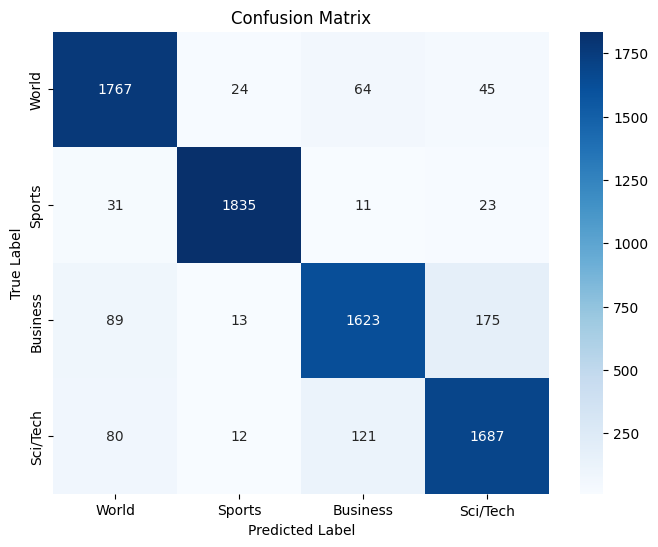

In [ ]:
model.eval() # Set the model to evaluation mode

all_preds = [] # List to store all predictions
all_labels = [] # List to store all true labels

with torch.no_grad(): # Disable gradient calculations
    for batch in val_loader:
        input_ids = batch["input_ids"].to(device, non_blocking=True)
        labels = batch["label"].to(self.device, non_blocking=True)

        logits = model(input_ids) # Get model outputs
        _, predicted = torch.max(logits, 1) # Get predicted class for each sample in batch

        all_preds.extend(predicted.cpu().numpy()) # Store predictions
        all_labels.extend(labels.cpu().numpy()) # Store true labels

cm = confusion_matrix(all_labels, all_preds) # Calculate the confusion matrix

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True, # Annotate cells with data values
    fmt="d", # Format annotations as integers
    cmap="Blues", # Color map for the heatmap
    xticklabels=[label_map[i] for i in sorted(label_map.keys())], # X-axis labels (predicted)
    yticklabels=[label_map[i] for i in sorted(label_map.keys())] # Y-axis labels (true)
)

plt.xlabel("Predicted Label") # X-axis title
plt.ylabel("True Label") # Y-axis title
plt.title("Confusion Matrix") # Plot title
plt.show() # Display the plot